In [9]:
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore')
plt.style.use('ggplot')

In [10]:
df1 = pd.read_csv('../../dataset/total_baseball_PCODE&배럴타구추가.csv')
df1['Date'] = df1["Date"].apply(lambda x : pd.to_datetime(str(x)))

In [11]:
df1

,NAME,날짜,상대,결과,점수,타순,P,선발,타수,득점,...,장타,OPS,투구,avLI,RE24,WPA,year,Date,PCODE,barrel
0,정훈,429,한화,W,4:3,7,3B,1,2,0,...,0.000,0.000,8,1.51,-0.72,-0.046,2018,2018-04-29,60523.0,0.0
1,정훈,502,KIA,L,6:12,6,1B,1,4,0,...,0.250,0.361,12,1.09,-0.33,-0.032,2018,2018-05-02,60523.0,0.0
2,정훈,504,@SK,L,4:5,9,PH,0,1,1,...,0.800,1.073,3,0.44,1.00,0.025,2018,2018-05-04,60523.0,1.0
3,정훈,508,@LG,W,4:2,5,PH,0,1,0,...,0.750,1.058,6,0.49,-0.26,-0.013,2018,2018-05-08,60523.0,0.0
4,정훈,510,@LG,W,7:2,9,PH,0,1,0,...,0.667,0.979,3,0.02,-0.26,-0.001,2018,2018-05-10,60523.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63447,김상수,829,@KT,L,3:8,9,2B,1,3,0,...,0.265,0.577,18,0.50,0.66,0.046,2021,2021-08-29,79402.0,NaN
63448,김상수,901,키움,W,7:1,9,2B,1,2,2,...,0.268,0.588,18,0.67,2.07,0.098,2021,2021-09-01,79402.0,NaN
63449,김상수,903,@KIA,W,9:3,6,2B,1,3,1,...,0.268,0.590,11,0.57,0.90,0.060,2021,2021-09-03,79402.0,NaN
63450,김상수,905,두산,L,5:6,9,2B,1,3,0,...,0.267,0.591,15,1.78,-0.02,-0.057,2021,2021-09-05,79402.0,NaN


In [12]:
#(2018, 2019, 2020 배럴타구 개수 평균) / (2018, 2019, 2020 전체 타수)
df_past = df1[df1['year'] == 2021]
barrel_mean = df_past.groupby(['PCODE'])['barrel'].sum() / df_past.groupby(['PCODE'])['타수'].sum()
barrel_mean

PCODE
50165.0    0.135135
50357.0    0.063830
50458.0    0.018605
50506.0    0.096463
50704.0    0.058252
             ...   
79240.0    0.084986
79365.0    0.076412
79402.0    0.064309
79456.0    0.035294
79608.0    0.073427
Length: 171, dtype: float64

In [13]:
df1.columns

Index(['NAME', '날짜', '상대', '결과', '점수', '타순', 'P', '선발', '타수', '득점', '안타', '2타',
       '3타', '홈런', '루타', '타점', '도루', '도실', '볼넷', '사구', '고4', '삼진', '병살', '희타',
       '희비', '타율', '출루', '장타', 'OPS', '투구', 'avLI', 'RE24', 'WPA', 'year',
       'Date', 'PCODE', 'barrel'],
      dtype='object')

In [14]:
window_size = 15

In [17]:
def make_time_series(df, window_size):
    columns_list = ['선발', '타수', '득점', '안타', '2타',
       '3타', '홈런', '루타', '타점', '도루', '도실', '볼넷', 
       '사구', '고4', '삼진', '병살', '희타',
       '희비', '투구', 'barrel']
    sample_list = []
    
    for pcode in tqdm(df1.PCODE.unique()):
        for year in [2018, 2019, 2020, 2021]:
            tmp_df = df1[(df1['PCODE'] == pcode) & (df1["Date"].dt.year == year)]
            tmp_df = tmp_df.sort_values(['NAME', "Date"])
            for idx, i in enumerate(range(1,len(tmp_df),window_size)):
                single = tmp_df[-i:-(i+window_size):-1].groupby(['PCODE','NAME','year'])[columns_list].sum()
                single['start_date'] = tmp_df[-i:-(i+window_size):-1].iloc[-1,-3]
                single['end_date'] = tmp_df[-i:-(i+window_size):-1].iloc[0,-3]
                single['gap'] = tmp_df[-i:-(i+window_size):-1].iloc[-1,-3] - tmp_df[-i:-(i+window_size):-1].iloc[0,-3]

                single['게임수'] = tmp_df[-i:-(i+window_size):-1].shape[0]
                single['출루']= single[['안타','2타','3타','홈런','사구','볼넷','고4']].sum(axis=1)/single[['타수','볼넷','고4','사구','희타']].sum(axis=1)
        
                single['장타'] = (single[['안타','2타','3타','홈런']] * [1,2,3,4]).sum(axis=1)/single['타수']

                single['series_index'] = 't' + str(idx)
                sample_list.append(single)

    return pd.concat(sample_list).reset_index()

In [18]:
result = make_time_series(df1, 15)
result

100%|██████████| 325/325 [01:02<00:00,  5.23it/s]


,PCODE,NAME,year,선발,타수,득점,안타,2타,3타,홈런,...,희비,투구,barrel,start_date,end_date,gap,게임수,출루,장타,series_index
0,60523.0,정훈,2018,5,31,5,12,2,0,2,...,0,125,4.0,2018-09-27,2018-10-14,-17 days,15,0.531250,0.774194,t0
1,60523.0,정훈,2018,1,17,8,6,1,1,1,...,0,82,1.0,2018-07-29,2018-09-26,-59 days,15,0.578947,0.882353,t1
2,60523.0,정훈,2018,6,29,3,9,1,0,0,...,1,143,2.0,2018-07-05,2018-07-27,-22 days,15,0.424242,0.379310,t2
3,60523.0,정훈,2018,4,26,4,7,0,0,1,...,0,145,1.0,2018-06-09,2018-07-04,-25 days,15,0.437500,0.423077,t3
4,60523.0,정훈,2018,8,41,7,10,2,0,1,...,1,189,9.0,2018-05-22,2018-06-08,-17 days,15,0.363636,0.439024,t4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4530,65132.0,김재성,2021,5,21,1,3,0,1,1,...,0,71,4.0,2021-05-13,2021-06-10,-28 days,15,0.304348,0.476190,t1
4531,65132.0,김재성,2021,5,15,2,3,1,0,0,...,0,70,5.0,2021-04-07,2021-05-11,-34 days,13,0.312500,0.333333,t2
4532,67644.0,이정훈,2021,12,46,3,7,1,0,0,...,0,232,0.0,2021-06-06,2021-08-11,-66 days,15,0.296296,0.195652,t0
4533,67644.0,이정훈,2021,15,57,8,19,4,0,1,...,0,288,8.0,2021-05-14,2021-06-04,-21 days,15,0.514706,0.543860,t1


In [19]:
non_barrel_index = result[result['start_date'] > '2021-07-11'].index
non_barrel_index

Int64Index([  20,   52,   87,  179,  273,  301,  330,  394,  440,  471,  490,
             542,  623,  706,  720,  736,  880,  909,  981,  995, 1030, 1068,
            1087, 1181, 1246, 1375, 1419, 1461, 1512, 1623, 1652, 1716, 1771,
            1889, 1955, 2013, 2092, 2144, 2180, 2271, 2400, 2459, 2486, 2516,
            2552, 2585, 2598, 2631, 2665, 2694, 2803, 2944, 2988, 3016, 3055,
            3194, 3289, 3367, 3398, 3446, 3484, 3581, 3622, 3687, 3733, 3757,
            3785, 3814, 3941, 3975, 4031, 4065, 4096, 4124, 4181, 4204, 4237,
            4254, 4300, 4318, 4349, 4396, 4410, 4433, 4441, 4454, 4464, 4478,
            4485, 4507, 4514],
           dtype='int64')

In [20]:
for idx in non_barrel_index:
    pcode = result.loc[idx, "PCODE"]
    result.loc[idx, 'barrel'] = round(barrel_mean[pcode] * result.loc[idx, '타수'])

In [42]:
result.to_csv('../../dataset/baseball_train_final_not_push.csv')

In [21]:
tmp_list = []

for pcode in tqdm(result.PCODE.unique()):
    for year in [2018, 2019, 2020, 2021]:
        if len(result[(result['PCODE'] == pcode) & (result["year"] == year)]) == 0: continue
        tmp = result[(result['PCODE'] == pcode) & (result["year"] == year)]
        
        tmp['장타'] = [None] + list(tmp['장타'].iloc[:-1])
        tmp['출루'] = [None] + list(tmp['출루'].iloc[:-1])

        tmp_list.append(tmp)

result2 = pd.concat(tmp_list)

100%|██████████| 325/325 [00:03<00:00, 83.73it/s] 


In [22]:
result2

,PCODE,NAME,year,선발,타수,득점,안타,2타,3타,홈런,...,희비,투구,barrel,start_date,end_date,gap,게임수,출루,장타,series_index
0,60523.0,정훈,2018,5,31,5,12,2,0,2,...,0,125,4.0,2018-09-27,2018-10-14,-17 days,15,NaN,NaN,t0
1,60523.0,정훈,2018,1,17,8,6,1,1,1,...,0,82,1.0,2018-07-29,2018-09-26,-59 days,15,0.531250,0.774194,t1
2,60523.0,정훈,2018,6,29,3,9,1,0,0,...,1,143,2.0,2018-07-05,2018-07-27,-22 days,15,0.578947,0.882353,t2
3,60523.0,정훈,2018,4,26,4,7,0,0,1,...,0,145,1.0,2018-06-09,2018-07-04,-25 days,15,0.424242,0.379310,t3
4,60523.0,정훈,2018,8,41,7,10,2,0,1,...,1,189,9.0,2018-05-22,2018-06-08,-17 days,15,0.437500,0.423077,t4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4530,65132.0,김재성,2021,5,21,1,3,0,1,1,...,0,71,4.0,2021-05-13,2021-06-10,-28 days,15,0.192308,0.173913,t1
4531,65132.0,김재성,2021,5,15,2,3,1,0,0,...,0,70,5.0,2021-04-07,2021-05-11,-34 days,13,0.304348,0.476190,t2
4532,67644.0,이정훈,2021,12,46,3,7,1,0,0,...,0,232,0.0,2021-06-06,2021-08-11,-66 days,15,NaN,NaN,t0
4533,67644.0,이정훈,2021,15,57,8,19,4,0,1,...,0,288,8.0,2021-05-14,2021-06-04,-21 days,15,0.296296,0.195652,t1


In [23]:
train_df = result2[result2['출루'].notnull()].reset_index(drop=True)
train_df

,PCODE,NAME,year,선발,타수,득점,안타,2타,3타,홈런,...,희비,투구,barrel,start_date,end_date,gap,게임수,출루,장타,series_index
0,60523.0,정훈,2018,1,17,8,6,1,1,1,...,0,82,1.0,2018-07-29,2018-09-26,-59 days,15,0.531250,0.774194,t1
1,60523.0,정훈,2018,6,29,3,9,1,0,0,...,1,143,2.0,2018-07-05,2018-07-27,-22 days,15,0.578947,0.882353,t2
2,60523.0,정훈,2018,4,26,4,7,0,0,1,...,0,145,1.0,2018-06-09,2018-07-04,-25 days,15,0.424242,0.379310,t3
3,60523.0,정훈,2018,8,41,7,10,2,0,1,...,1,189,9.0,2018-05-22,2018-06-08,-17 days,15,0.437500,0.423077,t4
4,60523.0,정훈,2018,5,28,6,9,4,0,2,...,0,108,5.0,2018-05-01,2018-05-20,-19 days,15,0.363636,0.439024,t5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3751,65040.0,김태훈,2021,4,12,0,3,0,0,0,...,0,51,1.0,2021-05-27,2021-06-08,-12 days,6,0.317073,0.435897,t2
3752,65132.0,김재성,2021,5,21,1,3,0,1,1,...,0,71,4.0,2021-05-13,2021-06-10,-28 days,15,0.192308,0.173913,t1
3753,65132.0,김재성,2021,5,15,2,3,1,0,0,...,0,70,5.0,2021-04-07,2021-05-11,-34 days,13,0.304348,0.476190,t2
3754,67644.0,이정훈,2021,15,57,8,19,4,0,1,...,0,288,8.0,2021-05-14,2021-06-04,-21 days,15,0.296296,0.195652,t1


In [38]:
train_df = train_df[train_df['타수'] >= 40]

In [39]:
len(train_df)

2242

<AxesSubplot:xlabel='타수', ylabel='Density'>

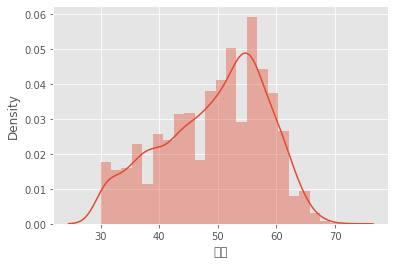

In [37]:
sns.distplot(train_df['타수'])

In [24]:
pred_player_list = [76232, 68050, 75847, 67341, 79192,78224, 78513, 76290, 79215, 67872]

In [25]:
test_all = result2[result2['출루'].isnull()].reset_index(drop=True)

In [26]:
test_df = test_all[(test_all['PCODE'].apply(lambda x : x in pred_player_list)) & (test_all['year']==2021)]

<AxesSubplot:ylabel='Density'>

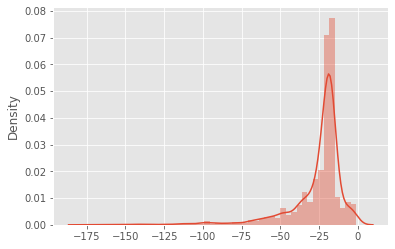

In [27]:
sns.distplot(x = result['gap'].apply(lambda x : x.days))

In [40]:
train_df.to_csv('../../dataset/baseball_train_final2.csv', index=False)
test_df.to_csv('../../dataset/baseball_test_final.csv', index=False)